In [1]:
import pandas as pd

from fluxo.dados import Dados
from fluxo.carga_dados import CargaDados
from fluxo.limpeza_dados import LimpezaDados
from fluxo.preprocessamento import Preprocessamento
from fluxo.extracao_caracteristicas import ExtracaoCaracteristicas
from fluxo.treinamento import Treinamento
from fluxo.classificador import Classificador
from fluxo.persistencia_modelo import PersistenciaModelo

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import joblib

In [2]:
pd.set_option('max_colwidth', 180)

In [3]:
# Definição do tipo de ato
# Valores válidos: 'ADE', 'SC' ou 'Port.'
# O valor desta variável influencia todo o comportamento deste notebook
tipo_ato = 'SC'

## Carga de Dados

In [4]:
dados = Dados()

In [5]:
cg = CargaDados()
cg.executar(dados)

11:36:55 - Carregando dados de segmentos...
11:36:55 - 206488 registros carregados.


## Limpeza de Dados

In [6]:
lp = LimpezaDados(dados)
lp.executar(dados, tipo_ato, reclassificar_nao_identificados=True)

11:36:55 - (Re)Carregando segmentos originais...
11:36:55 - Removendo segmentos nulos...
11:36:55 - 1900 segmentos nulos excluídos.
11:36:55 - Restaram 204588 segmentos não nulos.
11:36:55 - Removendo todos os segmentos do tipo Anexo...
11:36:55 - 5771 segmentos do tipo Anexo excluídos.
11:36:55 - Determinando tipos de segmento (labels) para atos do tipo SC...
11:36:55 - Tipos de segmento para atos SC: ['Ementa', 'Fecho', 'Não Identificado']
11:36:55 - Excluindo segmentos dos atos que não são SC...
11:36:55 - 188070 segmentos de atos não SC excluídos.
11:36:55 - Restaram 10747 segmentos de atos SC.
11:36:55 - Removendo segmentos não representativos para o tipo SC...
11:36:55 - 100 segmentos não representativos excluídos.
11:36:55 - Restaram 10647 segmentos representativos.
11:36:55 - Removendo tags HTML...
11:36:55 - Removendo caracteres de escape HTML...
11:36:56 - Reclassificando segmentos não identificados...
11:36:56 - Removendo segmentos classificados através de REGEX...
11:36:56 

## Preprocessamento

In [7]:
pp = Preprocessamento()
pp.executar(dados)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/91872936504/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
11:36:56 - Convertendo caracteres para minúsculo...
11:36:56 - Removendo pontuação...
11:36:56 - Realizando tokenização...
11:36:56 - Removendo stopwords...
11:36:57 - Removendo tokens menores que 2 caracteres...
11:36:57 - Reconstruindo texto a partir dos tokens...
11:36:57 - Preprocessamento concluído.


## Extração de Características

In [8]:
ec = ExtracaoCaracteristicas(dados)
ec.executar(dados, oversampling=True)

11:36:57 - Executando vetorização TF-IDF...
11:36:59 - Executando vetorização TF-IDF para Cross-Validation...
11:37:01 - Extração de características concluída.


## Treinamento e Teste

In [9]:
t = Treinamento()

In [10]:
# Linear SVC (SVM)
estimadorSVC = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR', estimadorSVC))

# Multinomial Naive Bayes 
estimadorNB = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR', estimadorNB))

In [11]:
t.treinar_modelos(dados)

11:37:02 - Treinando modelo LinearSVC-1xR...
11:37:02 - Treinamento do modelo LinearSVC-1xR concluído.
11:37:02 - Treinando modelo MultinomialNB-1xR...
11:37:02 - Treinamento do modelo MultinomialNB-1xR concluído.


## Treinamento e Teste com Cross-Validation

In [12]:
t = Treinamento()

In [13]:
# Linear SVC (SVM)
estimadorSVC_CV = LinearSVC(random_state=dados.random_state)
t.adicionar_modelo(Classificador('LinearSVC-1xR-CV', estimadorSVC_CV))

# Multinomial Naive Bayes 
estimadorNB_CV = OneVsRestClassifier(MultinomialNB())
t.adicionar_modelo(Classificador('MultinomialNB-1xR-CV', estimadorNB_CV))

In [14]:
t.treinar_modelos(dados, cv=5)

11:37:02 - Treinando modelo LinearSVC-1xR-CV com cross-validation...
11:37:06 - Treinamento do modelo LinearSVC-1xR-CV com cross-validation concluído.
11:37:06 - Treinando modelo MultinomialNB-1xR-CV com cross-validation...
11:37:07 - Treinamento do modelo MultinomialNB-1xR-CV com cross-validation concluído.


## Apresentação de Resultados

In [15]:
resultado = pd.DataFrame(dados.metricas)
resultado.transpose()

,acuracia,precisao,revocacao,f1
LinearSVC-1xR,0.9906,0.9933,0.9872,0.9902
MultinomialNB-1xR,0.8291,0.9043,0.8088,0.8278
LinearSVC-1xR-CV,0.9798,0.9803,0.9798,0.9797
MultinomialNB-1xR-CV,0.7828,0.7886,0.7828,0.7844


In [16]:
#print(resultado.transpose().to_latex())

### Matriz de Confusão para o classificador LinearSVC com Cross-Validation

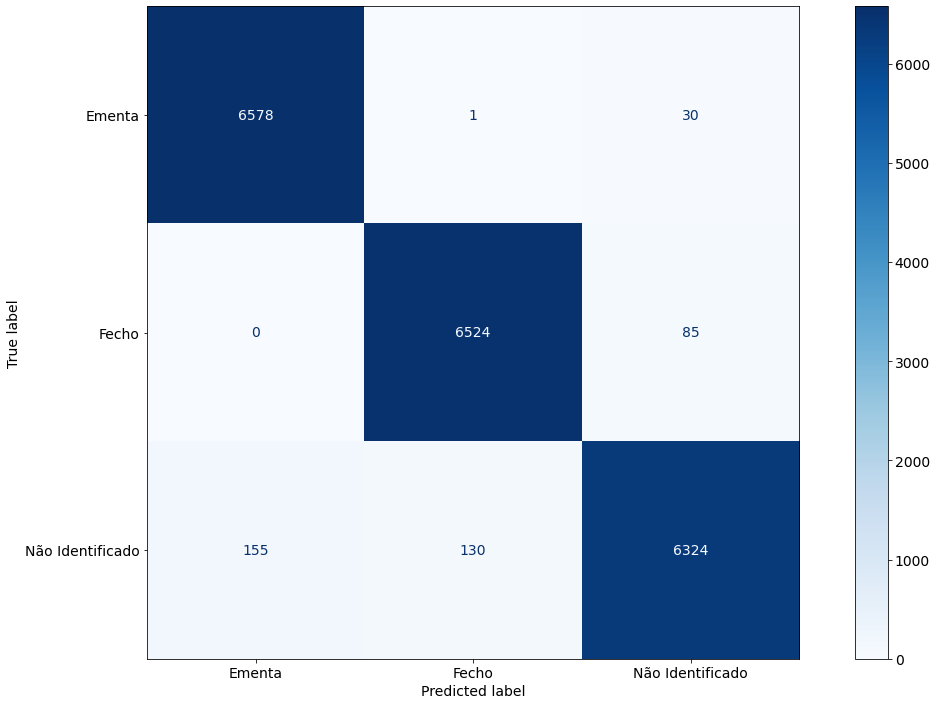

In [17]:
clf = t.buscar_modelo('LinearSVC-1xR-CV')
clf.plotar_matriz_confusao(dados.labels)


## Persistindo o modelo treinado

### Retreinando o modelo para o conjunto completo de dados

In [18]:
clf.treinar_sem_split(dados.X, dados.y)

In [19]:
pm = PersistenciaModelo('./modelos/')
pm.salvar_modelo(clf.estimador, tipo_ato)
pm.salvar_vetorizador(ec.vectorizer, tipo_ato)

11:37:08 - Salvando modelo treinado para o tipo SC...
11:37:08 - Modelo salvo em ./modelos/classificador-segmentos-sc.mdl.
11:37:08 - Salvando vetorizador para o tipo SC...
11:37:08 - Vetorizador salvo em ./modelos/vetorizador-sc.mdl.
